<a href="https://colab.research.google.com/github/subhadeepk/cse437-assignments/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 500
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [4]:
def epsilon_greedy(state, epsilon):
  if random.random() < epsilon:
    return env.action_space.sample()
  else:
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
      q_values = q_net(state)
    return torch.argmax(q_values).item()


In [5]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [6]:
## MAIN Loop ###
rewards_dqn = []
replay_buffer = []
num_episodes = 300

for episode in range(num_episodes):

  state = env.reset()[0]
  total_reward = 0
  done = False
  if episode < num_episodes - 10:
    epsilon = 0.005 #1 - episode/num_episodes
  else:
    epsilon = 0

  while not done:
    action = epsilon_greedy(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    state = next_state
    total_reward += reward
    train_dqn()
  print(" Reward in Episode no:", episode, "::", total_reward)
  rewards_dqn.append(total_reward)

/tmp/ipython-input-1929135722.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states).to(device)


 Reward in Episode no: 0 :: -2366.0
 Reward in Episode no: 1 :: -1789.0
 Reward in Episode no: 2 :: -8603.0
 Reward in Episode no: 3 :: -850.0
 Reward in Episode no: 4 :: -466.0
 Reward in Episode no: 5 :: -472.0
 Reward in Episode no: 6 :: -240.0
 Reward in Episode no: 7 :: -286.0
 Reward in Episode no: 8 :: -214.0
 Reward in Episode no: 9 :: -228.0
 Reward in Episode no: 10 :: -155.0
 Reward in Episode no: 11 :: -189.0
 Reward in Episode no: 12 :: -166.0
 Reward in Episode no: 13 :: -154.0
 Reward in Episode no: 14 :: -125.0
 Reward in Episode no: 15 :: -144.0
 Reward in Episode no: 16 :: -107.0
 Reward in Episode no: 17 :: -154.0
 Reward in Episode no: 18 :: -94.0
 Reward in Episode no: 19 :: -195.0
 Reward in Episode no: 20 :: -141.0
 Reward in Episode no: 21 :: -185.0
 Reward in Episode no: 22 :: -176.0
 Reward in Episode no: 23 :: -114.0
 Reward in Episode no: 24 :: -171.0
 Reward in Episode no: 25 :: -165.0
 Reward in Episode no: 26 :: -220.0
 Reward in Episode no: 27 :: -140.0


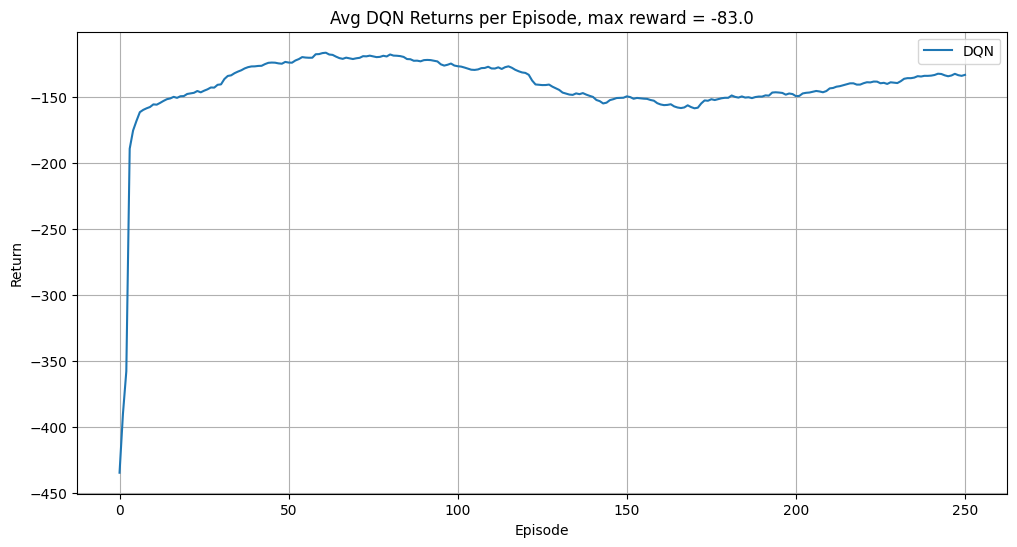

In [15]:
window_size = 50
moving_avg = np.convolve(rewards_dqn, np.ones(window_size)/window_size, mode='valid')
maximum_reward = np.max(rewards_dqn)

plt.figure(figsize=(12, 6))
plt.plot(moving_avg, label=f"DQN")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title(f"Avg DQN Returns per Episode, max reward = {maximum_reward}")
plt.legend()
plt.grid(True)
plt.show()

env.close()

In [27]:
# --- Plot: Final value function max_a Q(s,a) over a 2D grid ---
import numpy as np
import matplotlib.pyplot as plt
import torch
def plot_value_function(q_net, env, device, pos_points=121, vel_points=121):
    pos_low, vel_low = env.observation_space.low
    pos_high, vel_high = env.observation_space.high
    pos_grid = np.linspace(pos_low, pos_high, pos_points)
    vel_grid = np.linspace(vel_low, vel_high, vel_points)
    V = np.zeros((vel_points, pos_points), dtype=np.float32)  # rows: velocity, cols: position
    q_net.eval()
    with torch.no_grad():
        for i_v, v in enumerate(vel_grid):
            states = np.stack([np.array([p, v], dtype=np.float32) for p in pos_grid], axis=0)
            states_t = torch.from_numpy(states).to(device)
            q_vals = q_net(states_t)                         # [pos_points, n_actions]
            V[i_v, :] = torch.max(q_vals, dim=1).values.cpu().numpy()
    q_net.train()
    plt.figure()
    extent = [pos_low, pos_high, vel_low, vel_high]
    im = plt.imshow(V, origin="lower", aspect="auto", extent=extent)
    plt.colorbar(im, label="max_a Q(s, a)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("DQN Final Value Function: max_a Q(s, a)")
    plt.show()
# Call after training:
plot_value_function(q_net, env, device)

ValueError: too many values to unpack (expected 2)

Short write-up (also in the notebook):

**Performance of your DQN agent: How quickly does it learn? Does it reach the goal consistently?**

It learns to reach the goal in 50 episodes, and it also finds ways to reach the goal in very few steps(around 90). However, the final poliy does not converge to this easily, since the NN is trained with randomized batches.

**Comparison with tile coding:
Which representation learns faster?
Tile coding probably learns faster.**

Which one is more stable?
Tile coding is more stable.

**How do the function approximation choices (linear with tiles vs. neural network) affect generalization?**

Neural network is very general, as it should idelly be able to approximate any function. linear polynomial can only approximate linear functions. Tiling can approximate more complex functions(such as this one)

**Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
It did not. The default parameters worked pretty well.**

Insights: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?
The neural network finds it a bit hard to cnverge on the optimum policy because it is trained in randomized batches. Tiles on the other hand, converge faster.

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [19]:
!pip install swig
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 32.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409528 sha256=bbf2cee1f0bd359c9c40669a5a7828c06e3aea55d76c6bf8f97851f1ce3e4804
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import math

env = gym.make("LunarLander-v3")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []
Rewards = []



def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(Rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [21]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))


    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)


    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


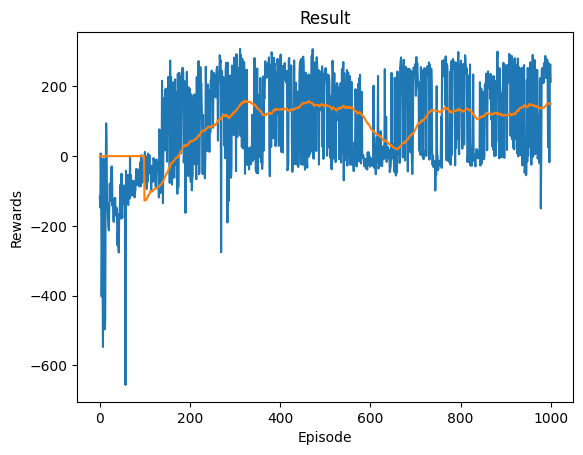

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [26]:
from itertools import count
# set up matplotlib
import matplotlib.pyplot as plt
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 1000
else:
    num_episodes = 1000


for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    Reward = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        Reward += reward
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            Rewards.append(Reward)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Short Write-up (≤1 page):

**Did your agent learn to land consistently?**
Yes the agent did learn to land consistently.

**How many episodes did it take before you saw improvement?**

I started to see improvement after around 150 episodes

**What effect did replay buffer size, target update frequency, and learning rate have on stability?**

A large replay buffer and a low target update frequency increses stability. Small batch size and small learning rate makes updates better. In general, a large batch size is better for stability.

**Compare results across different runs (does it sometimes fail to converge?).
Compare this task with the MountainCar-v0 problem you solved earlier:**

In the mountain car proble, the rewards were sparse. In the lunar lander, there is one big terminal reward, and smaller rewards along the way.

**What is extra or more challenging in LunarLander?
Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.**
The state space is 8 dimensional, compared to 2 in mountain car. Moreover, the dynamics in mountain car is smooth. In munar lander, that is not the case. it is more complicated and non-linear.


**Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?**
There were only two dimensions in the observation space for mountain car. In the lunar lander, its 8, which makes it really hard to tile code. NNs are better for non-linear function approximation in such cases.  